## Домашнее задание

### Предсказание зарплаты по названию/описанию должности методами классического машинного обучения

В этом домашнем задании потренируйтесь использовать классическое машинное обучение для решения задачи регрессии - предсказания зарплаты кандидата по названию/описанию должности.

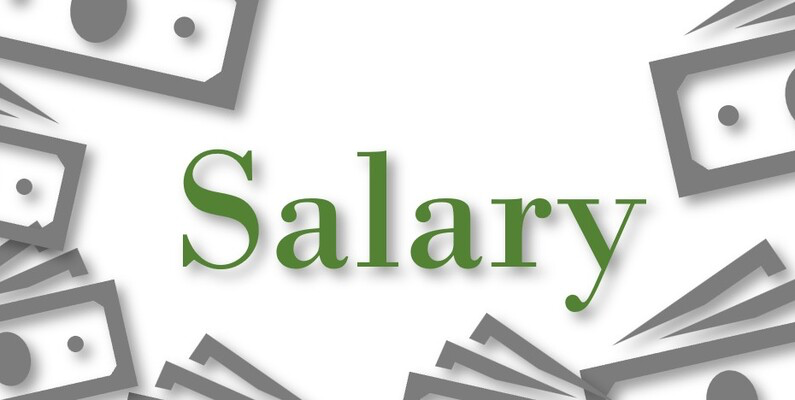

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy = True

## Задание

Считайте из файла `jobs.csv` первые 100_000 строк и выведите на экран первые 10 строк таблицы.


In [2]:
JOBS = 'https://www.dropbox.com/scl/fi/10z2fzgcldg9c0ghhekr9/jobs.csv?rlkey=j4b19zohmd8xai8zch42h5d7z&dl=1'

In [3]:
df = pd.read_csv(JOBS)[:100_000]

In [ ]:
df.head(10)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,72116516,Chartered Senior Quantity Surveyor,Award winning multi disciplinary consultancy a...,Somerset,Somerset,NaN,permanent,Resourcing Group,Consultancy Jobs,45000 - 55000/annum,50000,cv-library.co.uk
1,72547512,Net Developer VB / SQL Central Manchester *...,"A senior / experienced VB.Net Developer, with ...","Manchester, Greater Manchester, England, Great...",Manchester,NaN,permanent,CV Screen Ltd,IT Jobs,30000 - 45000/annum + benefits,37500,cv-library.co.uk
2,71680877,"Desktop Support Administrator Windows 7, Exch...","Desktop Support Administrator Windows 7, Exch...",Reading Berkshire South East,Reading,NaN,permanent,Spectrum IT,IT Jobs,26000 - 30000 per annum + excellent benefits,28000,totaljobs.com
3,70241394,Clinical Lead (RGN),RGN Clinical Lead Mid Glamorgan Very competiti...,Merthyr Tydfil Mid Glamorgan Wales,UK,NaN,permanent,BROOK STREET BUREAU Cardiff Care,Healthcare & Nursing Jobs,26026 - 29029 per annum + Benefits,27527,totaljobs.com
4,72692179,Charity Fundraisers GET PAID TO SAVE LIVES,CHARITY FUNDRAISING REPRESENTATIVES GET PAID ...,"Exeter,Devon,EXMOUTH,CREDITON,OTTERY ST MARY,D...",UK,NaN,permanent,Recruit4Talent,Sales Jobs,7 per hour + bonus,13440,jobsite.co.uk
5,70215534,Lift Consultant,"My Client is a multi national, multi disciplin...","Birmingham, West Midlands",Birmingham,NaN,permanent,FastTrack Management Services Limited,Engineering Jobs,35000 - 40000/annum 35 - 40K Plus Package,37500,cv-library.co.uk
6,71344495,Measured Surveyor,Our client a retail space planning/ surveying ...,Bristol,Bristol,NaN,contract,NaN,Property Jobs,100 per day,24000,hays.co.uk
7,71631064,Project Manager,"Project Manager (Oil and Gas Pumps, Vessels, v...","Stroud, Gloucestershire",Stroud,NaN,permanent,Luton Bennett Limited,Engineering Jobs,"28000 - 35000/annum 28,000 - 35,000",31500,cv-library.co.uk
8,49689064,Home Care Assistant / Home Carer Job in Maidst...,Bluebird Care is a leading provider of profess...,"Maidstone, Kent",Maidstone,part_time,NaN,NaN,Healthcare & Nursing Jobs,"Up to 16,500 per year",16500,careworx.co.uk
9,68628009,Exchange/Messaging Administrator x**** London,EXCHANGE ADMINISTRATOR MESSAGING MS EXCHANGE...,London City EC1A2,Central London,NaN,permanent,Spring Technology,IT Jobs,38000.00 - 57000.00 GBP Annual,47500,jobserve.com


## Задание

Постройте гистограмму распределения целевой переменной - это столбец `SalaryNormalized`.

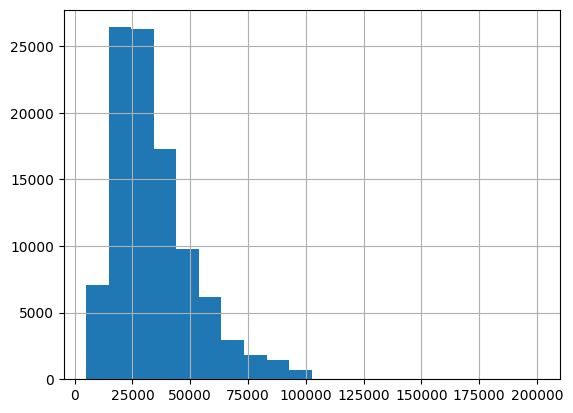

In [ ]:
df.SalaryNormalized.hist(bins=20);

## Quiz

Для каждой категории профессий (столбец `Category`) вычислите среднюю зарплату.

Отсортируйте результаты в порядке убывания средней зарплаты.

В какой категории средняя зарплата максимальна?

In [ ]:
df.groupby('Category').agg({'SalaryNormalized': 'mean'})

,SalaryNormalized
Category,
Accounting & Finance Jobs,38379.619805
Admin Jobs,21077.193422
Charity & Voluntary Jobs,28703.721639
Consultancy Jobs,37433.728528
Creative & Design Jobs,33085.919453
Customer Services Jobs,20023.179735
Domestic help & Cleaning Jobs,18242.223214
"Energy, Oil & Gas Jobs",46139.266065
Engineering Jobs,35710.654359


Прологарифмируем целевую переменную.

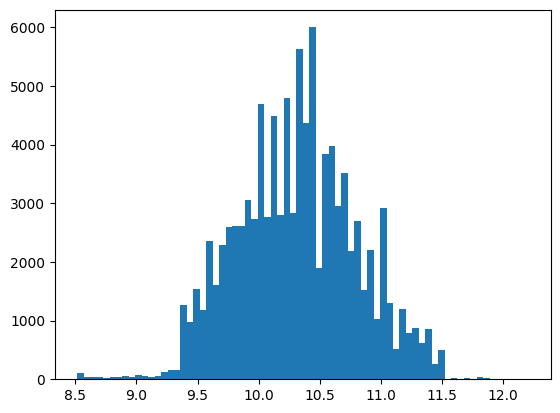

In [ ]:
plt.hist(np.log(df.SalaryNormalized), bins=70)
plt.show()

Она стала иметь распределение, более похожее на нормальное - это для нас удобно (многим моделям машинного обучения легче обучаться на нормально распределенных данных).

## Quiz

При помощи TfidfVectorizer с гиперпараметрами
`stop_words='english', min_df=5, max_df=1.0, ngram_range=(1, 1)`
закодируйте столбец с описанием вакансий (`FullDescription`).

Преобразованный столбец `FullDescription` сохраните в переменную `descr`.

Сколько столбцов получилось в матрице объект-признак после применения векторизации?

In [10]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0, ngram_range=(1, 1))

In [11]:
descr = tfidf.fit_transform(df.FullDescription)

In [ ]:
descr

<100000x29147 sparse matrix of type '<class 'numpy.float64'>'
	with 10569582 stored elements in Compressed Sparse Row format>

## Задание

При помощи `train_test_split` разбейте данные на тренировочную и тестовую части:

* в качестве матрицы признаков используйте закодированные описания вакансий `descr`

* вектор ответов - `np.log(df["SalaryNormalized"])`

В тест отправьте 20% данных, зафиксируйте `random_state=42`.

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(descr, np.log(df["SalaryNormalized"]), random_state=42, test_size=0.2)

## Quiz

Обучите Ridge-регрессию (с гиперпараметрами по умолчанию) на тренировочных данных и выведите качество модели ($R^2$) на трейне и на тесте.

В ответ запишите $R^2$ на тесте, округленное до сотых.

In [6]:
model = Ridge().fit(Xtrain, ytrain)

In [7]:
ypred = model.predict(Xtest)

In [8]:
r2 = r2_score(ytest, ypred)

In [9]:
round(r2, 2)

0.67

Посмотрим как работает ваша модель.

Так как мы обучали ее на логарифмированной зарплате, то от предсказания надо взять экспоненту (обратное преобразование).

Ниже `clf` - это обученная модель, а `tfidf` - обученный TfIdfVectorizer (у вас тут могут быть другие названия).

In [12]:
np.exp(model.predict(tfidf.transform([u"director"])))

array([94266.06045706])

In [13]:
np.exp(model.predict(tfidf.transform([u"manager"])))

array([60058.29749441])

## Quiz

Поэкспериментируйте с моделью. Вычислите предсказываемую моделью зарплату:

* junior window cleaner
* chief window cleaner
* chief window cleaner and big data

В ответ введите зарплату `chief window cleaner and big data`, округленную до целого числа.

In [15]:
np.exp(model.predict(tfidf.transform([u"chief window cleaner and big data"])))

array([29176.27333235])

## Quiz

Выведите на экран в виде pd.DataFrame топ-10 признаков с наибольшим положительным весом, а затем топ-10 признаков с наибольшим отрицательным весом.

Какой признак имеет наибольший отрицательный вес?

In [30]:
df_idf = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names_out(), columns=["idf_weights"])

In [35]:
df_idf.sort_values(by='idf_weights')

,idf_weights
experience,1.271215
role,1.479289
work,1.516653
team,1.553482
working,1.613718
...,...
racecourses,10.721176
rabin,10.721176
cellars,10.721176
census,10.721176


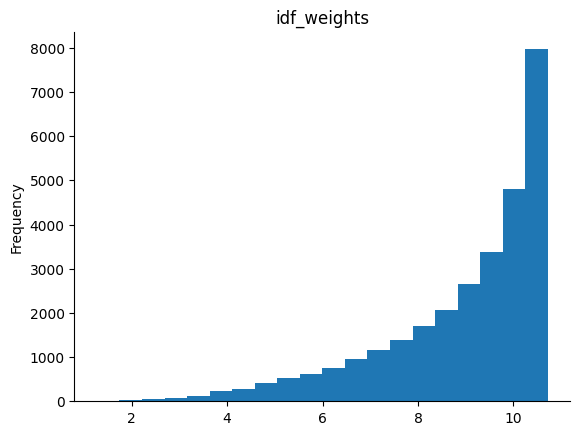

In [32]:
from matplotlib import pyplot as plt
df_idf['idf_weights'].plot(kind='hist', bins=20, title='idf_weights')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [36]:
importances = pd.DataFrame({'weights': model.coef_
                            ,'features': tfidf.get_feature_names_out()})\
                            .sort_values(by='weights')
importances

,weights,features
25323,-1.318648,studentship
1879,-1.210066,apprenticeship
19781,-1.167522,physio
1876,-1.122485,apprentice
17351,-1.062498,mta
...,...,...
15587,1.057912,locum
23459,1.077926,seanlejgroup
12154,1.145103,hcpc
7837,1.187117,director


## Бонус

Поэкспериментируйте с настройками:

* можно настраивать гиперпараметры в Tf-Idf кодировщике (или попробовать CountVectorizer)

* можно настраивать (при помощи GridSearchCV) гиперпараметр регуляризации `C` у Ridge-регрессии (или попробовать Lasso-регрессию).

Ваша цель - добиться наилучшего качества $R^2$ на тестовых данных.

In [ ]:
# ваш код здесь